In [ ]:
#Importation des pacquets nécessaires à l'estimation. 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# a) Statistiques descriptives

In [ ]:
#Transformation des variables en variables binaires (non-nécessaire)
weekly = pd.read_csv('weekly.csv')
weekly['Direction'] = weekly['Direction'].astype("string")
weekly['intdirection'] = weekly['Direction'].rank(method='dense')
weekly['intdirection'] = weekly['intdirection']-1
#Statistiques descriptives
display(weekly.describe())

FileNotFoundError: ignored

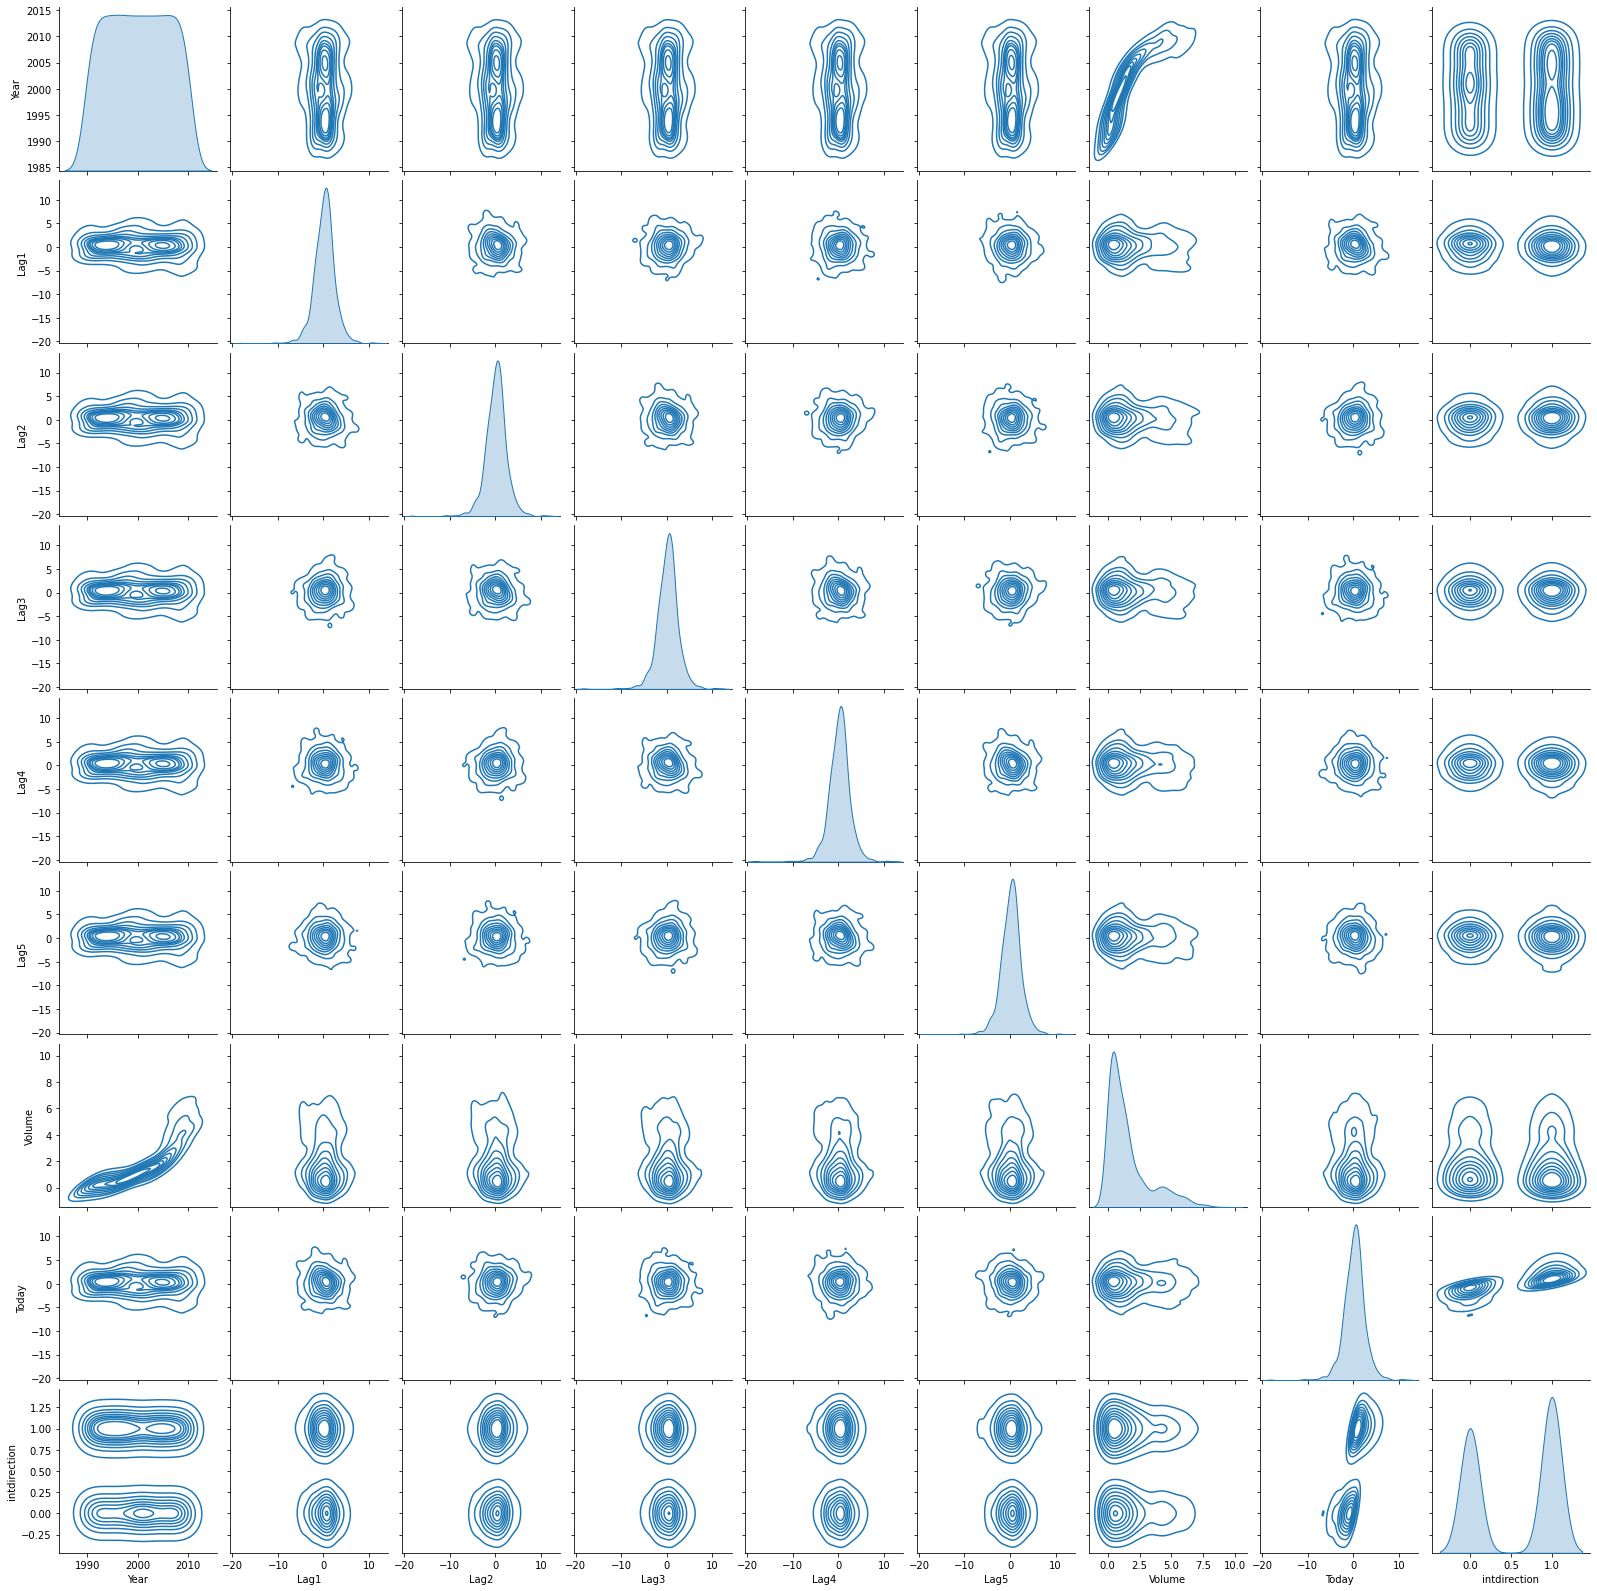

In [ ]:
sns.pairplot(weekly[['Year','Lag1','Lag2','Lag3','Lag4','Lag5','Volume','Today','intdirection']], kind="kde")
plt.show()

On peut observer qu'il y a une forte correlation positive entre l'année et le volume. Cependant, d'autres associations fortes ne sont pas évidentes.

# b) Estimation Logit

In [ ]:
model1 = smf.logit("intdirection ~ Lag1 + Lag2 + Lag3 + Lag4 + Lag5 + Volume", data = weekly).fit()
print(model1.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           intdirection   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Thu, 17 Feb 2022   Pseudo R-squ.:                0.006580
Time:                        19:49:08   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

On peut observer que les seuls coefficients significativement différents de zéro sont Lag2 et le paramètre constant (l'intercept).

# c) Matrice de confusion et fraction des observations correctes

In [ ]:
#Ici, nous assumons que le modèle prédit une hausse si la probabilité d'une hausse est supérieure à 50%
y_pred = pd.Series(round(model1.predict(weekly)))
y_true = pd.Series(weekly['intdirection'])
print(confusion_matrix(y_true, y_pred), classification_report(y_true, y_pred))




[[ 54 430]
 [ 48 557]]               precision    recall  f1-score   support

         0.0       0.53      0.11      0.18       484
         1.0       0.56      0.92      0.70       605

    accuracy                           0.56      1089
   macro avg       0.55      0.52      0.44      1089
weighted avg       0.55      0.56      0.47      1089



La matrice de confusion nous indique que notre modèle à tendance à faire des erreurs de type 2. En d'autres mots, le modèle prédit souvent une baisse dans la valeur de la bourse quand la bourse monte en réalité. En revanche, le modèle fait peu d'erreurs de type 1. Lorsqu'il prédit une hausse à la bourse, cette hausse à une forte probabilité de se produire. 

# d) Modèle Logit à un seul paramètre, test de valitidé externe.

In [ ]:
#Séparer les données pour l'entrainement et le test.
weekly_test = weekly.iloc[986:,:]
weekly_train = weekly.iloc[:985,:]
#Estimation logit
model2 = smf.logit("intdirection ~ Lag2", data = weekly_train).fit()
print(model2.summary())

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           intdirection   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Thu, 17 Feb 2022   Pseudo R-squ.:                0.003076
Time:                        19:49:08   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.

In [ ]:
#Récupérer les données test:
y2_pred = pd.Series(round(model2.predict(weekly_test)), name='prédiction')
y2_true = pd.Series(weekly_test['intdirection'])
print(confusion_matrix(y2_true, y2_pred), classification_report(y2_true, y2_pred))

[[ 9 33]
 [ 5 56]]               precision    recall  f1-score   support

         0.0       0.64      0.21      0.32        42
         1.0       0.63      0.92      0.75        61

    accuracy                           0.63       103
   macro avg       0.64      0.57      0.53       103
weighted avg       0.63      0.63      0.57       103



# e) estimation par LDA

In [ ]:
#Répéter les étapes précédentes avec LDA:
x_train3 = weekly.loc[weekly['Year']<=2008,['Lag2']]
x_test3 = weekly.loc[weekly['Year']>2008,['Lag2']]
y_train3 = weekly.loc[weekly['Year']<=2008, ['intdirection']]
y_test3 = weekly.loc[weekly['Year']>2008, ['intdirection']]
formula3 = 'intdirection ~ Lag2'
lda = LinearDiscriminantAnalysis()
model3 = lda.fit(x_train3, y_train3.values.ravel())
pred3 = model3.predict(x_test3)

In [ ]:
print(confusion_matrix(y_test3, pred3), classification_report(y_test3, pred3))

[[ 9 34]
 [ 5 56]]               precision    recall  f1-score   support

         0.0       0.64      0.21      0.32        43
         1.0       0.62      0.92      0.74        61

    accuracy                           0.62       104
   macro avg       0.63      0.56      0.53       104
weighted avg       0.63      0.62      0.57       104



# f) Estimation par QDA

In [ ]:
#Répéter les étapes précedentes pour QDA
qda = QuadraticDiscriminantAnalysis()
model4 = qda.fit(x_train3, y_train3.values.ravel())
pred4 = model4.predict(x_test3)
print(confusion_matrix(pred4, y_test3), (classification_report(y_test3, pred4)))


[[ 0  0]
 [43 61]]               precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        43
         1.0       0.59      1.00      0.74        61

    accuracy                           0.59       104
   macro avg       0.29      0.50      0.37       104
weighted avg       0.34      0.59      0.43       104



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# g) Estimation par KNN avec K=1

In [ ]:
#Répéter les étapes précedentes pour KNN avec K=1
KNN = KNeighborsClassifier(n_neighbors=1)
model5 = KNN.fit(x_train3, y_train3.values.ravel())
pred5 = model5.predict(x_test3)

In [ ]:
print(confusion_matrix(pred5, y_test3), (classification_report(y_test3, pred5)))

[[22 32]
 [21 29]]               precision    recall  f1-score   support

         0.0       0.41      0.51      0.45        43
         1.0       0.58      0.48      0.52        61

    accuracy                           0.49       104
   macro avg       0.49      0.49      0.49       104
weighted avg       0.51      0.49      0.49       104



# h) Quel modèle à la meilleure performance?
En comparant les modèles, on observe que le premier modèle logit à une précision moyenne de 55%, le deuxième modèle logit à une précision moyenne de 64%, le modèle LDA à une précision moyenne de 63%, le modèle QDA une précision moyenne de 29% et le modèle KNN avec K=1 une précision moyenne de 49%. Étant donné ces résultats, nous concluons que le meilleur modèle testé est le deuxième modèle logit, en raison de sa performance globale. 

# I) Modèles alternatifs

In [ ]:
#Répéter les étapes précedentes pour KNN avec K=2
KNN = KNeighborsClassifier(n_neighbors=2)
model5 = KNN.fit(x_train3, y_train3.values.ravel())
pred5 = model5.predict(x_test3)
print(confusion_matrix(pred5, y_test3), (classification_report(y_test3, pred5)))

[[31 44]
 [12 17]]               precision    recall  f1-score   support

         0.0       0.41      0.72      0.53        43
         1.0       0.59      0.28      0.38        61

    accuracy                           0.46       104
   macro avg       0.50      0.50      0.45       104
weighted avg       0.51      0.46      0.44       104



In [ ]:
#Répéter les étapes précedentes pour KNN avec K=4
KNN = KNeighborsClassifier(n_neighbors=4)
model5 = KNN.fit(x_train3, y_train3.values.ravel())
pred5 = model5.predict(x_test3)
print(confusion_matrix(pred5, y_test3), (classification_report(y_test3, pred5)))

[[26 27]
 [17 34]]               precision    recall  f1-score   support

         0.0       0.49      0.60      0.54        43
         1.0       0.67      0.56      0.61        61

    accuracy                           0.58       104
   macro avg       0.58      0.58      0.57       104
weighted avg       0.59      0.58      0.58       104



Pour l'algorithme KNN, K=4 semble produire le meilleur résultat. Cependant, ce résultat est toujours inférieur aux deuxième modèle logit.

In [ ]:
#Construction de nouveaux paramètres
x_trainyear = weekly.loc[weekly['Year']<=2008,['Year']]
x_testyear = weekly.loc[weekly['Year']>2008,['Year']]
y_train6 = weekly.loc[weekly['Year']<=2008, ['intdirection']]
y_test6 = weekly.loc[weekly['Year']>2008, ['intdirection']]
x_train6 = x_train3.append(x_trainyear)
x_test6 = x_test3.append(x_testyear)


In [ ]:
model6 = smf.logit("intdirection ~ Lag2 + Year", data = weekly).fit()
print(model6.summary())

Optimization terminated successfully.
         Current function value: 0.684113
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           intdirection   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Thu, 17 Feb 2022   Pseudo R-squ.:                0.004147
Time:                        20:20:38   Log-Likelihood:                -745.00
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.04495
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     13.3776     20.302      0.659      0.510     -26.413      53.168
Lag2           0.0622      0.

Contrairement à nos attentes, l'inclusion de l'année de l'observation n'a pas eu d'effet positif sur la qualité de l'estimé.

In [ ]:

model7 = smf.logit("intdirection ~ Lag2 + I(Lag2**2)", data = weekly).fit()
print(model7.summary())

Optimization terminated successfully.
         Current function value: 0.683826
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           intdirection   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1086
Method:                           MLE   Df Model:                            2
Date:                Thu, 17 Feb 2022   Pseudo R-squ.:                0.004564
Time:                        20:29:52   Log-Likelihood:                -744.69
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                   0.03290
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1910      0.066      2.916      0.004       0.063       0.319
Lag2             0.0676

L'addition d'un terme quadratique à Lag2 n'a pas amélioré la qualité de l'ajustement. 

In [ ]:
model8 = smf.logit("intdirection ~ Lag2 + I(Volume**2)+I(Volume*Lag2)", data = weekly).fit()
print(model8.summary())

Optimization terminated successfully.
         Current function value: 0.684221
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:           intdirection   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1085
Method:                           MLE   Df Model:                            3
Date:                Thu, 17 Feb 2022   Pseudo R-squ.:                0.003990
Time:                        20:31:23   Log-Likelihood:                -745.12
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1131
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2203      0.069      3.198      0.001       0.085       0.355
Lag2       

L'addition d'un terme d'intéraction n'a pas amélioré la qualité de l'ajustement non plus. Le meilleur modèle est donc toujours le modèle logit:

In [ ]:
print(confusion_matrix(y2_true, y2_pred), classification_report(y2_true, y2_pred))

[[ 9 33]
 [ 5 56]]               precision    recall  f1-score   support

         0.0       0.64      0.21      0.32        42
         1.0       0.63      0.92      0.75        61

    accuracy                           0.63       103
   macro avg       0.64      0.57      0.53       103
weighted avg       0.63      0.63      0.57       103

